# Import libraries

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils.utils import pd_dict_filt, nanargsort
from src.utils.sort_utils import map_position_index, center_array, split_main_mirror

# Read metadata

In [3]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,age,Manufacturer,Inner cable type,Outer cable type,I_Q_SM18,Renamed short magnet ID,MTF Status,Magnet_construction_order,QPS Crate Number,Cryostat Number
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,14.0,3.0,01B,02B8,11488.0,NaN,NaN,288,0,0
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,14.0,2.0,01E,02C0,10622.0,NaN,NaN,256,0,1
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,14.0,2.0,01E,02C9,12427.0,NaN,NaN,330,1,0
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,14.0,2.0,01E,02C9,11155.0,NaN,NaN,319,2,1
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,14.0,1.0,01E,02B8,11782.0,NaN,NaN,296,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,14.0,3.0,01B,02G,12645.0,NaN,NaN,123,1,1
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,14.0,1.0,01B,02B5,12379.0,NaN,NaN,62,1,0
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,14.0,2.0,01B,02K,11757.0,NaN,NaN,61,2,1
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,14.0,3.0,01B,02G,11656.0,NaN,NaN,172,0,0


# Define position map

In [4]:
pos_map = rb_magnet_metadata[["Circuit", "Magnet", "#Electric_circuit", "phys_pos"]].rename(columns = {"#Electric_circuit": "El. Position", "phys_pos": "Phys. Position"}) #.sort_values(by=["circuit","El. Position"])

# python index starts with 0
pos_map[["El. Position", "Phys. Position"]] = pos_map[["El. Position", "Phys. Position"]] - 1

In [5]:
# for each circuit get index to sort by
phys_pos_index_odd = pos_map[pos_map.Circuit=='RB.A12']["Phys. Position"].values 
phys_pos_index_even_in_odd = pos_map[pos_map.Circuit=='RB.A12']["Phys. Position"].values[::-1] 
phys_pos_index_even = np.array([[d, c] for c, d in zip(phys_pos_index_even_in_odd[::2], phys_pos_index_even_in_odd[1::2])]).flatten()

for circuit in pos_map["Circuit"].unique():
    if  int(circuit[4]) % 2 == 0:
        pc_dist_index = phys_pos_index_even
    else: 
        pc_dist_index = phys_pos_index_even_in_odd 
        
    #TODO: only right for odd index:
    pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Dist. to PC"] = pc_dist_index
    pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Position ODD"] = phys_pos_index_odd
    pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Position EVEN"] = phys_pos_index_even

In [6]:
# for each circuit get index to sort by
# current sort is by phys position, so we need to transform the range 0-154 to the oposite sites
phys_pos_index = pos_map[pos_map.Circuit=='RB.A12']["Phys. Position"].values 
phys_pos_index_even_in_odd = pos_map[pos_map.Circuit=='RB.A12']["Phys. Position"].values[::-1] 
phys_pos_index_odd_in_even = pos_map[pos_map.Circuit=='RB.A23']["Phys. Position"].values[::-1] 
phys_pos_index_even = np.array([[d, c] for c, d in zip(phys_pos_index_even_in_odd[::2], phys_pos_index_even_in_odd[1::2])]).flatten()
phys_pos_index_odd = np.array([[d, c] for c, d in zip(phys_pos_index_odd_in_even[::2], phys_pos_index_odd_in_even[1::2])]).flatten()

for circuit in pos_map["Circuit"].unique():
    if  int(circuit[4]) % 2 == 0:
        pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Dist. to PC"] = phys_pos_index
        pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Position ODD"] = phys_pos_index_odd
        pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Position EVEN"] = phys_pos_index
    else: 
        # it already works for odd circuits
        pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Dist. to PC"] = phys_pos_index_even_in_odd
        pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Position ODD"] = phys_pos_index
        pos_map.loc[pos_map["Circuit"]==circuit, "Phys. Position EVEN"] = phys_pos_index_even

In [32]:
# inflate df, add quench position. Size of df gets (8*154)*154
df_list = []
for q in pos_map[pos_map.Circuit=='RB.A12']["Phys. Position"].values:
    for circuit in pos_map["Circuit"].unique():
        el_quench_pos = map_position_index(pos_map, old_index=np.array(q, dtype=int), origin="El. Position", to="Phys. Position", filt={"Circuit":circuit})[0]
        pos_map.loc[pos_map["Circuit"]==circuit, "El. Quench Position"] = el_quench_pos
    pos_map["Phys. Quench Position"] = q
    df_list.append(pos_map.copy())
    
pos_map_q = pd.concat(df_list)

In [33]:
# add Distances to Quench 
for circuit in pos_map["Circuit"].unique():
    for q in np.arange(154):
        el_quench_pos = map_position_index(pos_map, old_index=[q], origin="El. Position", to="Phys. Position", filt={"Circuit":circuit})[0]
        
        phys_bool = (pos_map_q["Circuit"]== circuit) & (pos_map_q["Phys. Quench Position"]==q)
        df = pos_map_q[phys_bool] 
        pos_map_q.loc[phys_bool, "Phys. Dist. to Quench"] = nanargsort(center_array(df["Phys. Position"].values, q))

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
../src/utils/utils.py:87: RuntimeWarning: invalid value

In [34]:
# add Distances to Quench el. Position
# switch to el. Position sort
pos_map_q = pos_map_q.sort_values(by="El. Position")
for circuit in pos_map["Circuit"].unique():
    for q in np.arange(154):       
        el_bool = ((pos_map_q["Circuit"]== circuit) & (pos_map_q["El. Quench Position"]==q)).values
        df = pos_map_q[el_bool] 
        
        
        main_index, mirror_index = split_main_mirror(df["El. Position"].values, q)
        el_bool_full_main = el_bool.copy()
        el_bool_main = el_bool_full_main[el_bool]
        el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
        el_bool_full_main[el_bool] = el_bool_main
        
        el_bool_full_mirror = el_bool.copy()
        el_bool_mirror = el_bool_full_mirror[el_bool]
        el_bool_mirror[main_index[main_index >=0].astype(int)] = False
        el_bool_full_mirror[el_bool] = el_bool_mirror

        pos_map_q.loc[el_bool_full_main, "El. Dist. to Quench Main"] = nanargsort(main_index)
        pos_map_q.loc[el_bool_full_mirror,  "El. Dist. to Quench Mirror"] = nanargsort(mirror_index)

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
 

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_main[mirror_index[mirror_index >=0].astype(int)] = False
<ipython-input-34-6b47e54f44f6>:18: RuntimeWarning: invalid value encountered in greater_equal
  el_bool_mirror[main_index[main_index >=0].astype(int)] = False
../src/utils/utils.py:87: RuntimeWarning: invalid value encountered in greater_equal
  return np.argsort(array)[(np.sort(array) >= 0)]
<ipython-input-34-6b47e54f44f6>:13: RuntimeWarning: invalid value encountered in great

In [35]:
# convert float to int
nan_columns = pos_map_q.isna().any(axis=0)
int_columns = pos_map_q.loc[:,~nan_columns].drop(columns=['Circuit', 'Magnet']).columns
pos_map_q[int_columns] = pos_map_q[int_columns].astype(int)

In [38]:
filt = {"Circuit":"RB.A12", "El. Quench Position": 0} 
pd_dict_filt(pos_map_q, filt).sort_values(by="El. Position").reset_index(drop=True).T 

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
Circuit,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,...,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12
Magnet,MB.A8L2,MB.A9L2,MB.A10L2,MB.A11L2,MB.A12L2,MB.C12L2,MB.B13L2,MB.A14L2,MB.C14L2,MB.B15L2,...,MB.C15L2,MB.A15L2,MB.B14L2,MB.C13L2,MB.A13L2,MB.B12L2,MB.B11L2,MB.B10L2,MB.B9L2,MB.B8L2
El. Position,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
Phys. Position,153,151,149,147,145,143,141,139,137,135,...,134,136,138,140,142,144,146,148,150,152
Phys. Dist. to PC,0,2,4,6,8,10,12,14,16,18,...,19,17,15,13,11,9,7,5,3,1
Phys. Position ODD,153,151,149,147,145,143,141,139,137,135,...,134,136,138,140,142,144,146,148,150,152
Phys. Position EVEN,1,3,5,7,9,11,13,15,17,19,...,18,16,14,12,10,8,6,4,2,0
El. Quench Position,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Phys. Quench Position,153,153,153,153,153,153,153,153,153,153,...,153,153,153,153,153,153,153,153,153,153
Phys. Dist. to Quench,154,152,150,148,146,144,142,140,138,136,...,135,137,139,141,143,145,147,149,151,153


In [39]:
filt = {"Circuit":"RB.A23", "El. Quench Position": 0} 
pd_dict_filt(pos_map_q, filt).sort_values(by="El. Position").reset_index(drop=True).T 

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
Circuit,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23,...,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23,RB.A23
Magnet,MB.B8R2,MB.B9R2,MB.B10R2,MB.B11R2,MB.B12R2,MB.A13R2,MB.C13R2,MB.B14R2,MB.A15R2,MB.C15R2,...,MB.B15R2,MB.C14R2,MB.A14R2,MB.B13R2,MB.C12R2,MB.A12R2,MB.A11R2,MB.A10R2,MB.A9R2,MB.A8R2
El. Position,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
Phys. Position,1,3,5,7,9,11,13,15,17,19,...,18,16,14,12,10,8,6,4,2,0
Phys. Dist. to PC,1,3,5,7,9,11,13,15,17,19,...,18,16,14,12,10,8,6,4,2,0
Phys. Position ODD,153,151,149,147,145,143,141,139,137,135,...,134,136,138,140,142,144,146,148,150,152
Phys. Position EVEN,1,3,5,7,9,11,13,15,17,19,...,18,16,14,12,10,8,6,4,2,0
El. Quench Position,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Phys. Quench Position,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Phys. Dist. to Quench,154,156,158,160,162,164,166,168,170,172,...,171,169,167,165,163,161,159,157,155,153


In [40]:
pos_map_q.reset_index(drop=True).to_csv("../data/circuit_sort.csv",index=False)

# Map index

In [13]:
filt = {"Circuit":"RB.A12", "El. Quench Position": 0} 
phys_dist = map_position_index(pos_map_q, origin="El. Position", to= 'Phys. Dist. to Quench', filt=filt)
phys_dist

array([ 77,  76,  78,  75,  79,  74,  80,  73,  81,  72,  82,  71,  83,
        70,  84,  69,  85,  68,  86,  67,  87,  66,  88,  65,  89,  64,
        90,  63,  91,  62,  92,  61,  93,  60,  94,  59,  95,  58,  96,
        57,  97,  56,  98,  55,  99,  54, 100,  53, 101,  52, 102,  51,
       103,  50, 104,  49, 105,  48, 106,  47, 107,  46, 108,  45, 109,
        44, 110,  43, 111,  42, 112,  41, 113,  40, 114,  39, 115,  38,
       116,  37, 117,  36, 118,  35, 119,  34, 120,  33, 121,  32, 122,
        31, 123,  30, 124,  29, 125,  28, 126,  27, 127,  26, 128,  25,
       129,  24, 130,  23, 131,  22, 132,  21, 133,  20, 134,  19, 135,
        18, 136,  17, 137,  16, 138,  15, 139,  14, 140,  13, 141,  12,
       142,  11, 143,  10, 144,   9, 145,   8, 146,   7, 147,   6, 148,
         5, 149,   4, 150,   3, 151,   2, 152,   1, 153,   0])

# Test Indexes

In [14]:
pos_map_q = pd.read_csv("..\data\circuit_sort.csv")

In [15]:
import sys
from pathlib import Path
sys.path.insert(0,'..')

from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.utils.frequency_utils import get_fft_of_DataArray
from src.visualisation.fft_visualisation import plot_position_frequency_map

In [16]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()
fpa_identifiers = ['RB_RB.A78_1615271973700000000']
dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])


max_freq = 360
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE.data, cutoff_frequency=max_freq)

In [17]:
circuit = str(fpa_identifiers[0]).split('_')[1]
data = dataset_1EE_fft[{'event': 0}].data
frequency = dataset_1EE_fft[{'event': 0}].frequency

sort_columns = ['El. Position', 'Phys. Position', 'Phys. Position ODD', 'Phys. Position EVEN', 'Phys. Dist. to PC', 'Phys. Dist. to Quench', 'El. Dist. to Quench Main', 'El. Dist. to Quench Mirror']

el_quench_pos = 109
filt = {"Circuit":circuit, "El. Quench Position": el_quench_pos}

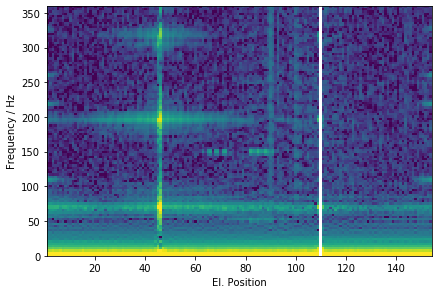

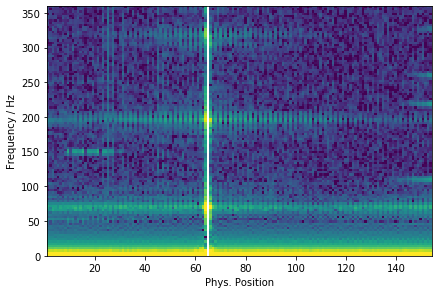

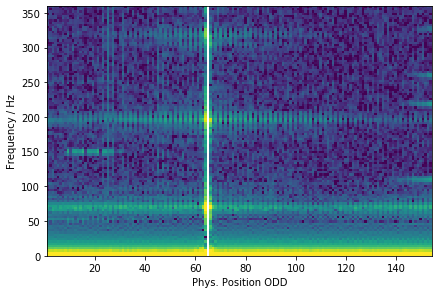

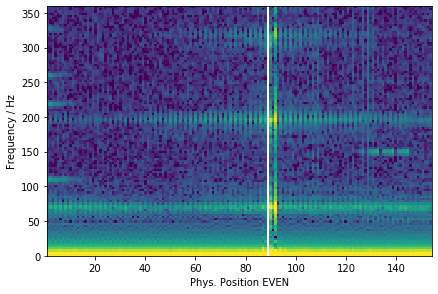

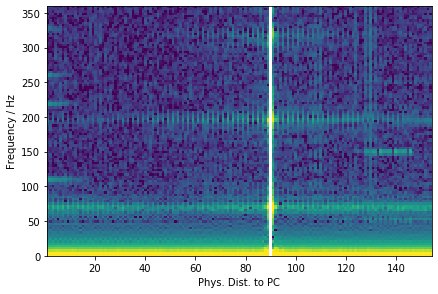

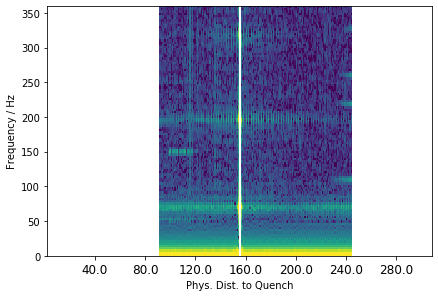

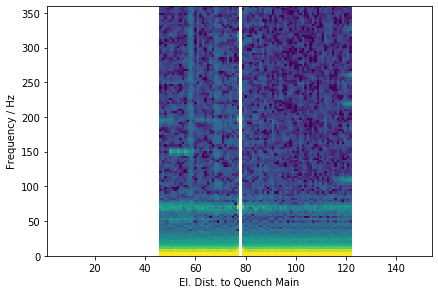

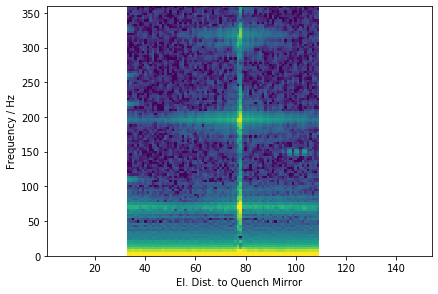

In [18]:
for target in sort_columns:
    
    pos_map_subset = pd_dict_filt(pos_map_q, filt)
    index = map_position_index(pos_map_subset, origin="El. Position", to=target)
    max_index = int(pos_map_q[target].max())
    target_index = map_position_index(pos_map_subset, origin=target, to=target)
    data_plot = np.zeros((max_index+1, data.shape[-1]))

    data_plot[target_index] = data[index]
        
    fig, ax = plt.subplots()
    plot_position_frequency_map(ax, data_plot, frequency)  
    
    if target == 'Phys. Dist. to Quench':
        xticks = ax.get_xticks().tolist()
        ax.set_xticklabels([2*a for a in xticks], fontsize="large")
    
    ax.set_xlabel(target)
    ax.set_ylabel("Frequency / Hz")
    plt.show()
